<a href="https://colab.research.google.com/github/kuzovkov/neural-university/blob/main/%D0%94%D0%97_Pro_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [2]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Выходящий', 'Входящий']

In [3]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [4]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['04914.jpg', '00777.jpg', '03734.jpg', '00286.jpg', '00149.jpg', '03951.jpg', '03294.jpg', '00788.jpg', '01411.jpg', '03376.jpg', '01400.jpg', '01105.jpg', '05114.jpg', '06165.jpg', '00067.jpg', '00653.jpg', '01149.jpg', '05048.jpg', '03142.jpg', '04107.jpg', '05729.jpg', '03094.jpg', '01596.jpg', '05221.jpg', '01332.jpg', '06465.jpg', '02067.jpg', '02826.jpg', '01753.jpg', '02823.jpg', '01020.jpg', '05200.jpg', '04770.jpg', '03471.jpg', '05585.jpg', '03474.jpg', '04415.jpg', '05781.jpg', '05418.jpg', '01835.jpg', '01298.jpg', '02864.jpg', '00576.jpg', '00890.jpg', '04529.jpg', '03292.jpg', '04608.jpg', '04172.jpg', '02843.jpg', '00494.jpg', '00198.jpg', '06029.jpg', '03120.jpg', '00396.jpg', '01937.jpg', '06318.jpg', '05454.jpg', '03912.jpg', '02115.jpg', '02820.jpg', '05670.jpg', '02518.jpg', '04951.jpg', '04355.jpg', '01832.jpg', '04730.jpg', '02555.jpg', '00848.jpg', '06321.jpg', '04037.jpg', '05285.jpg', '02589.jpg', '01119.jpg', '00424.jpg', '01304.jpg', '04482.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

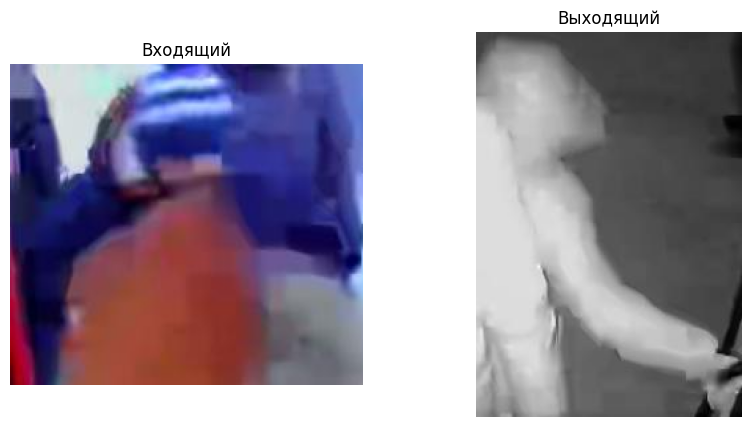

In [5]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [6]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [7]:
# ваше решение
# Задание единых размеров изображений

IMG_WIDTH = 64                           # Ширина изображения
IMG_HEIGHT = 128                           # Высота изображения

import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

# Нормированние массива изображений
x_data = x_data / 255.


В массив собрано 9081 фотографий следующей формы: (128, 64, 3)
Общий массив данных изображений следующей формы: (9081, 128, 64, 3)
Общий массив меток классов следующей формы: (9081,)


In [11]:
# Подключение нужных слоев из модуля tensorflow.keras.layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(128, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(128, (3, 3), name='Second_C', padding='same', activation='relu'))  # (64,128,256) --> (64,128,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (64,128,256) --> (21,42,256)

# Третий сверточный блок
model.add(Conv2D(128, (3, 3), name='Third_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(Dropout(0.2, name='Third_D'))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(128, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (21,42,256) --> (7,14,256)
model.add(Dropout(0.2, name='Fourth_D'))  # (7,14,256) --> (7,14,256) нет изменений

# Пятый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(512, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)
model.add(Dropout(0.2, name='Sixth_D'))  # (2,4,1024) --> (2,4,1024) нет изменений

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (2,4,1024) --> (2*4*1024) --> (8192)
model.add(Dense(1024, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(2048, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(2, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ First_C (Conv2D)                     │ (None, 128, 64, 128)        │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ First_B (BatchNormalization)         │ (None, 128, 64, 128)        │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_C (Conv2D)                    │ (None, 128, 64, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_M (MaxPooling2D)              │ (None, 42, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_C (Conv2D)                     │ (None, 42, 21, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_B (BatchNormalization)         │ (None, 42, 21, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_D (Dropout)                    │ (None, 42, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_C (Conv2D)                    │ (None, 42, 21, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_M (MaxPooling2D)              │ (None, 14, 7, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_D (Dropout)                   │ (None, 14, 7, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_D (Conv2D)                     │ (None, 14, 7, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_B (BatchNormalization)         │ (None, 14, 7, 256)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_C (Conv2D)                     │ (None, 14, 7, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_M (MaxPooling2D)               │ (None, 4, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_D (Dropout)                    │ (None, 4, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_1 (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_2 (Dense)                      │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_3 (Dense)                      │ (None, 2048)                │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_4 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,222,338 (31.37 MB)

 Trainable params: 8,221,314 (31.36 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [12]:
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


In [13]:
# Обучение модели сверточной нейронной сети подготовленных данных
store_learning = model.fit(x_data,  # ----------------- x_train, примеры набора данных
                           y_data,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           shuffle=True,  # ----------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=25,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=25,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 45s 109ms/step - accuracy: 0.8902 - loss: 0.3530 - val_accuracy: 0.0000e+00 - val_loss: 1.4364
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9255 - loss: 0.2019 - val_accuracy: 0.1585 - val_loss: 2.0479
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9505 - loss: 0.1471 - val_accuracy: 0.5696 - val_loss: 0.8808
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9595 - loss: 0.1145 - val_accuracy: 0.7391 - val_loss: 0.5249
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9676 - loss: 0.0993 - val_accuracy: 0.6753 - val_loss: 0.8130
Epoch 6/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9676 - loss: 0.0966 - val_accuracy: 0.7573 - val_loss: 0.6289
Epoch 7/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9771 - loss: 0.0618 - val_accuracy: 0.8905 - val_loss: 0.2565
Epoch 8/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9853 - loss: 0.04

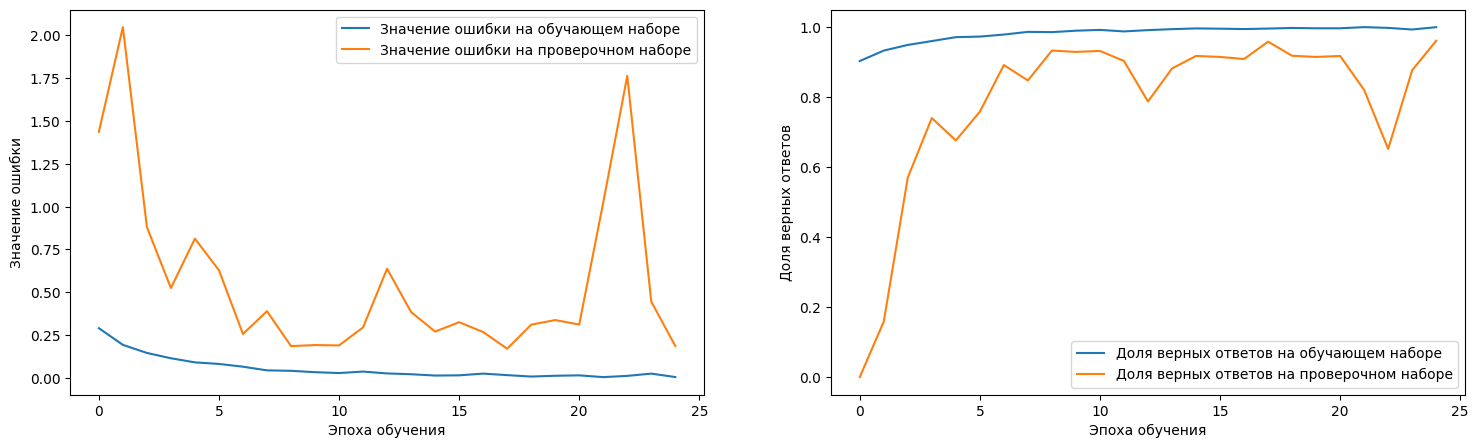

In [14]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(store_learning.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(store_learning.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(store_learning.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(store_learning.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()
